In [1]:
# 📊 Day 13: Project — EDA + Visualization
# Author: David Caleb Chaparro Orozco
# Topic: Exploratory Data Analysis and Visualization of Sales Forecasting Dataset

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
import scipy
import squarify

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Create directories if they don't exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [2]:
# Load the data
data = pd.read_csv("data/processed_sales_data.csv")
data.head()

,CustomerID,Category,SubCategory,OrderYear,OrderMonth,OrderWeekday,ShippingDuration,ShipModeFirstClass,ShipModeSecondClass,ShipModeStandardClass,SegmentEncoded,CityFreqEncoded,SalesLog,SalesScaled,SalesBinned,SalesPerShippingDay,Sales_mean,Sales_count,ShippingDuration_mean,Sales
0,CG-12520,Furniture,Bookcases,2017,11,2,3,False,True,False,0,0.005210,5.572002,0.050928,Very High,65.490000,229.756000,5,1.400000,261.9600
1,CG-12520,Furniture,Chairs,2017,11,2,3,False,True,False,0,0.005210,6.597064,0.802571,Very High,182.985000,229.756000,5,1.400000,731.9400
2,DV-13045,Office Supplies,Labels,2017,6,0,4,False,True,False,1,0.074369,2.748552,-0.344645,Low,2.924000,124.387000,9,4.222222,14.6200
3,SO-20335,Furniture,Tables,2016,10,1,7,False,False,True,0,0.001328,6.865450,1.163435,Very High,119.697187,173.505033,15,5.533333,957.5775
4,SO-20335,Office Supplies,Storage,2016,10,1,7,False,False,True,0,0.001328,3.151368,-0.332254,Medium,2.796000,173.505033,15,5.533333,22.3680


## 1. Numeric Features Distribution


📊 Numeric Features Distribution:


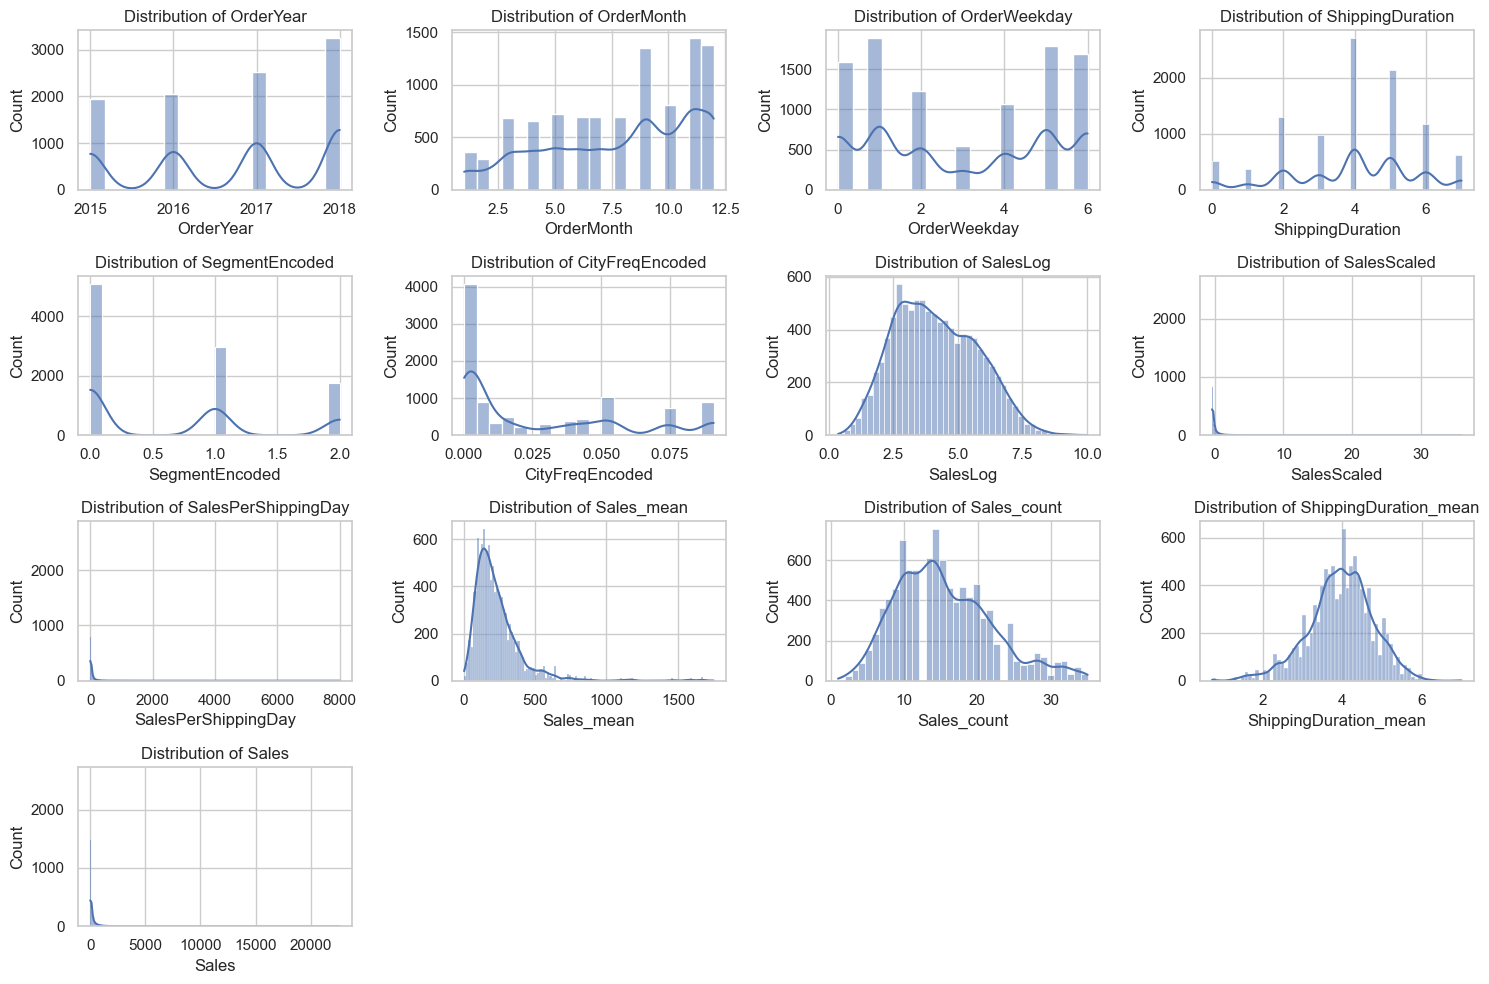

In [3]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()

print("\n📊 Numeric Features Distribution:")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.savefig('outputs/numeric_distributions.png')
plt.show()

## 2. Categorical Features Distribution

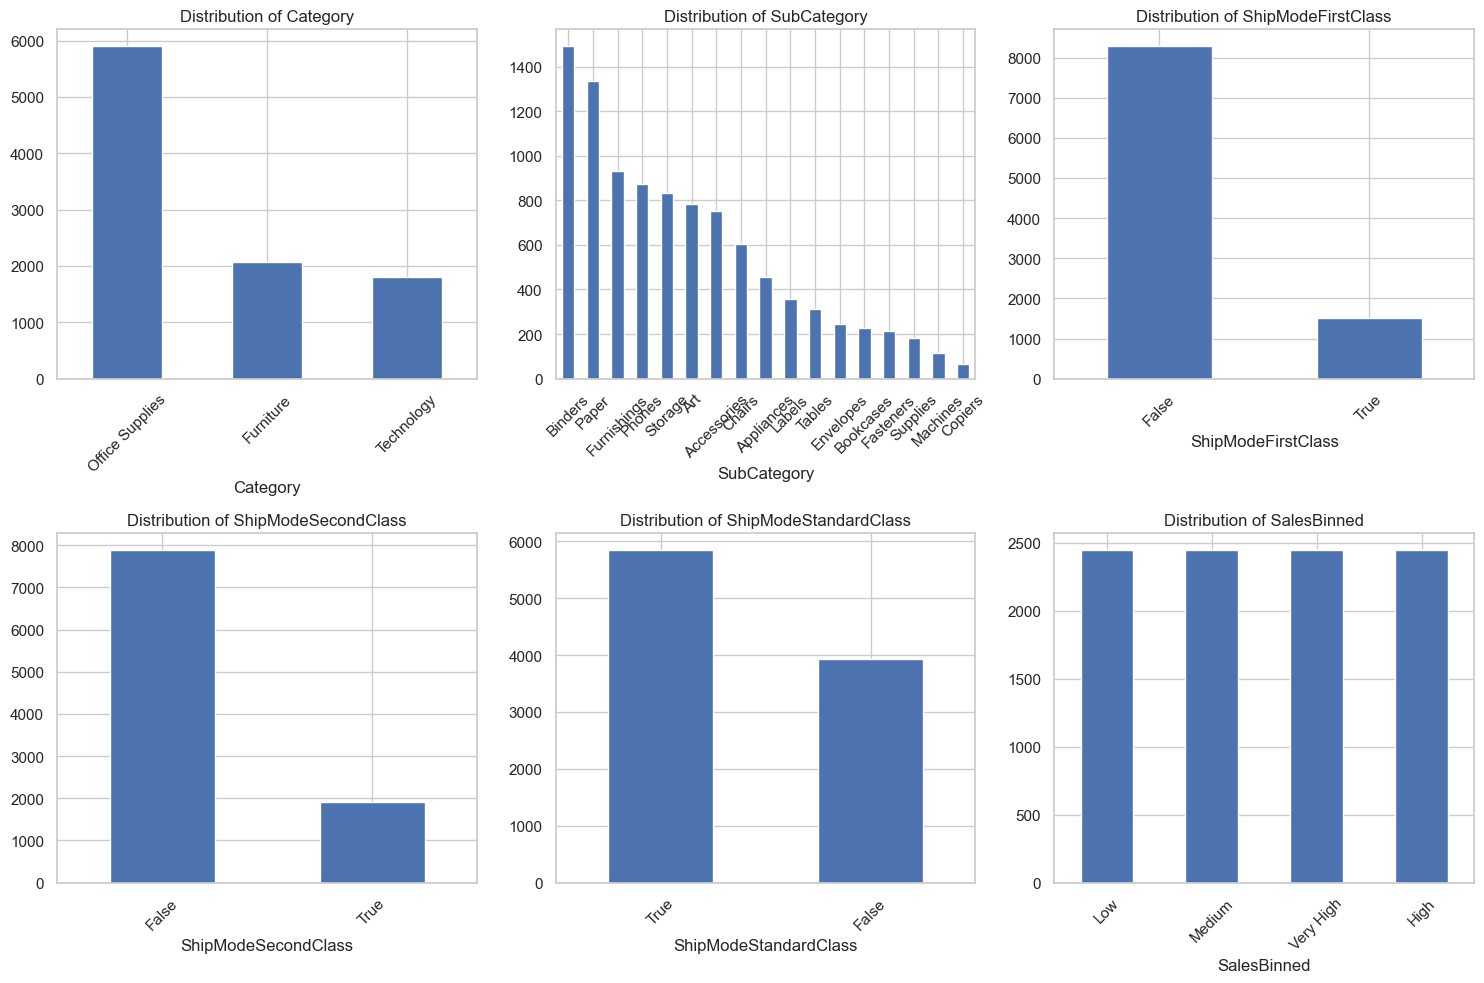

In [4]:
cols_to_plot = [col for col in categorical_cols if col != 'CustomerID']

n_cols = 3
n_rows = math.ceil(len(cols_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    data[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('outputs/categorical_distributions.png')
plt.show()


## 3. Improved Visualizations for Skewness & Outliers

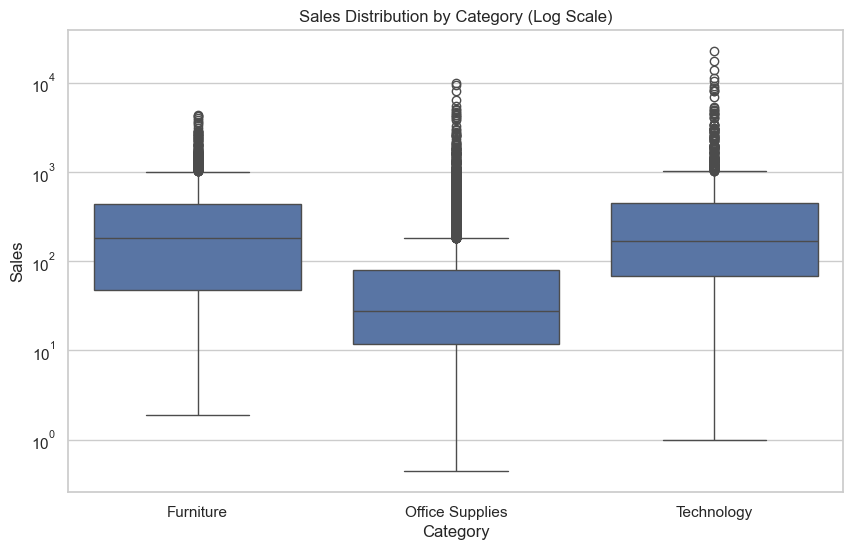

In [5]:
# Log Scale on Sales
plt.figure(figsize=(10,6))
sns.boxplot(x='Category', y='Sales', data=data)
plt.yscale('log')
plt.title("Sales Distribution by Category (Log Scale)")
plt.show()

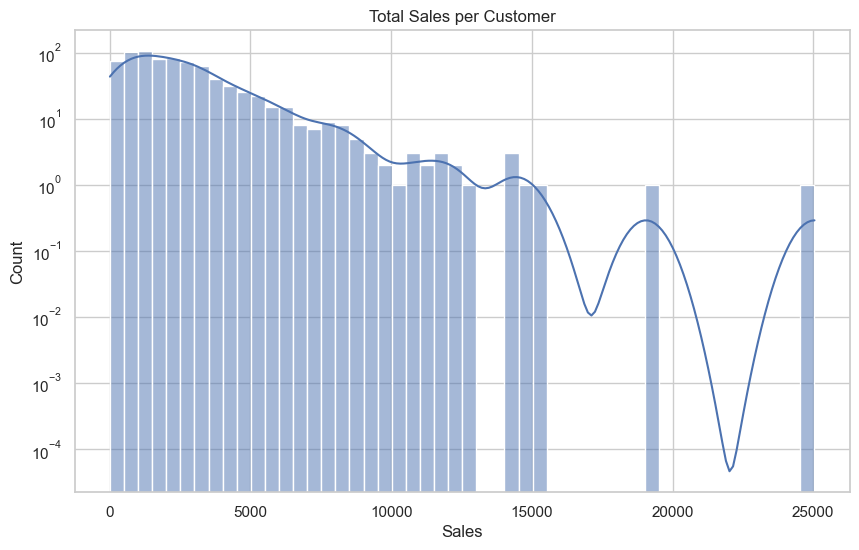

In [6]:
# Aggregate Sales (per Customer or per Category)
customer_sales = data.groupby("CustomerID")["Sales"].sum().reset_index()

plt.figure(figsize=(10,6))
sns.histplot(customer_sales["Sales"], bins=50, kde=True)
plt.title("Total Sales per Customer")
plt.yscale("log")  # optional
plt.show()

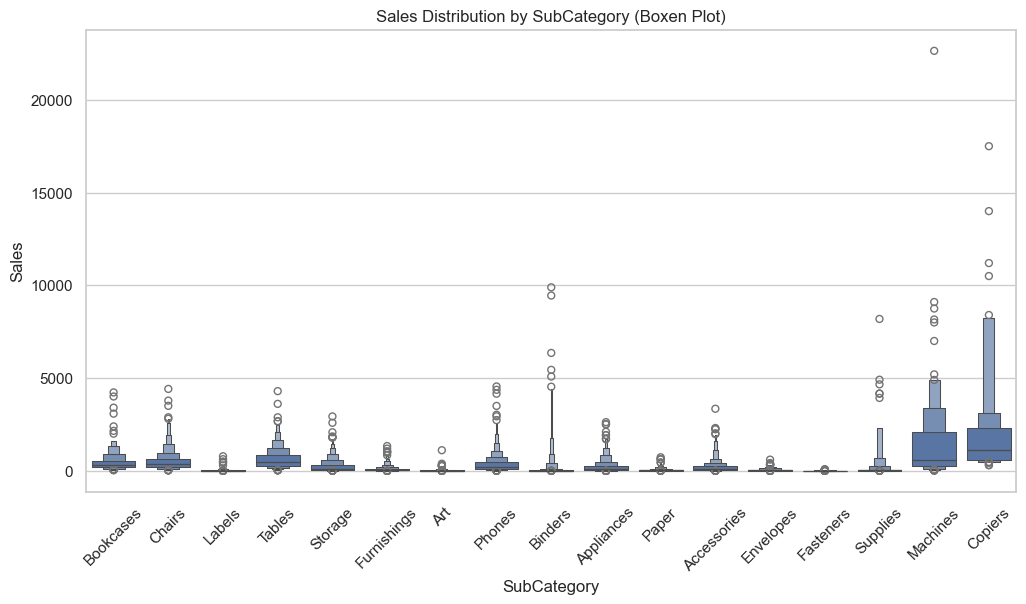

In [7]:
# Use Boxen Plots for SubCategory
plt.figure(figsize=(12,6))
sns.boxenplot(x="SubCategory", y="Sales", data=data)
plt.xticks(rotation=45)
plt.title("Sales Distribution by SubCategory (Boxen Plot)")
plt.show()


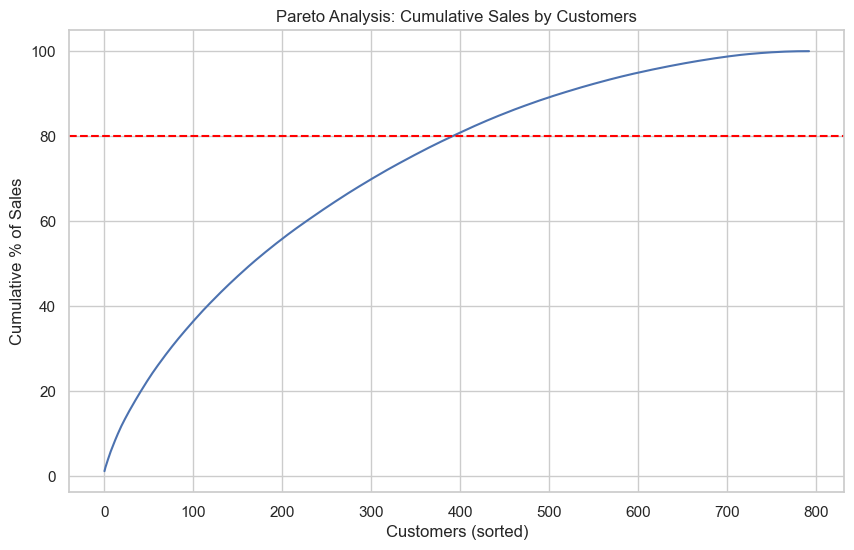

In [8]:
# Pareto Analysis
customer_sales = data.groupby("CustomerID")["Sales"].sum().sort_values(ascending=False).reset_index()
customer_sales["CumulativePct"] = customer_sales["Sales"].cumsum() / customer_sales["Sales"].sum() * 100

plt.figure(figsize=(10,6))
sns.lineplot(x=customer_sales.index, y=customer_sales["CumulativePct"])
plt.axhline(80, color="red", linestyle="--")
plt.title("Pareto Analysis: Cumulative Sales by Customers")
plt.xlabel("Customers (sorted)")
plt.ylabel("Cumulative % of Sales")
plt.show()


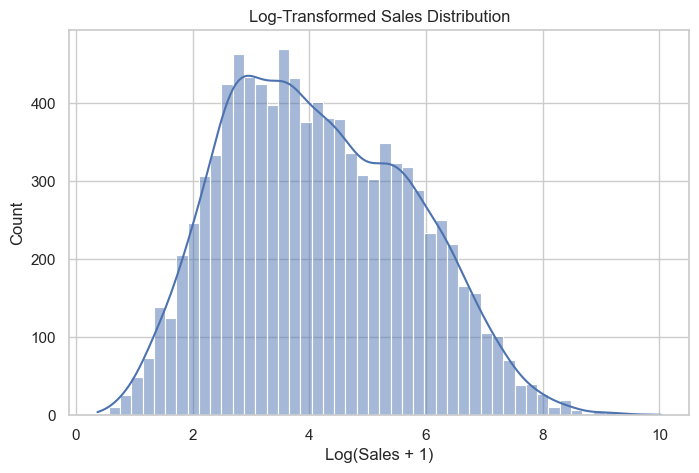

In [9]:
# Log-Transformed Distribution
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(data["Sales"]), bins=50, kde=True)
plt.title("Log-Transformed Sales Distribution")
plt.xlabel("Log(Sales + 1)")
plt.show()


## 4. Correlation Analysis

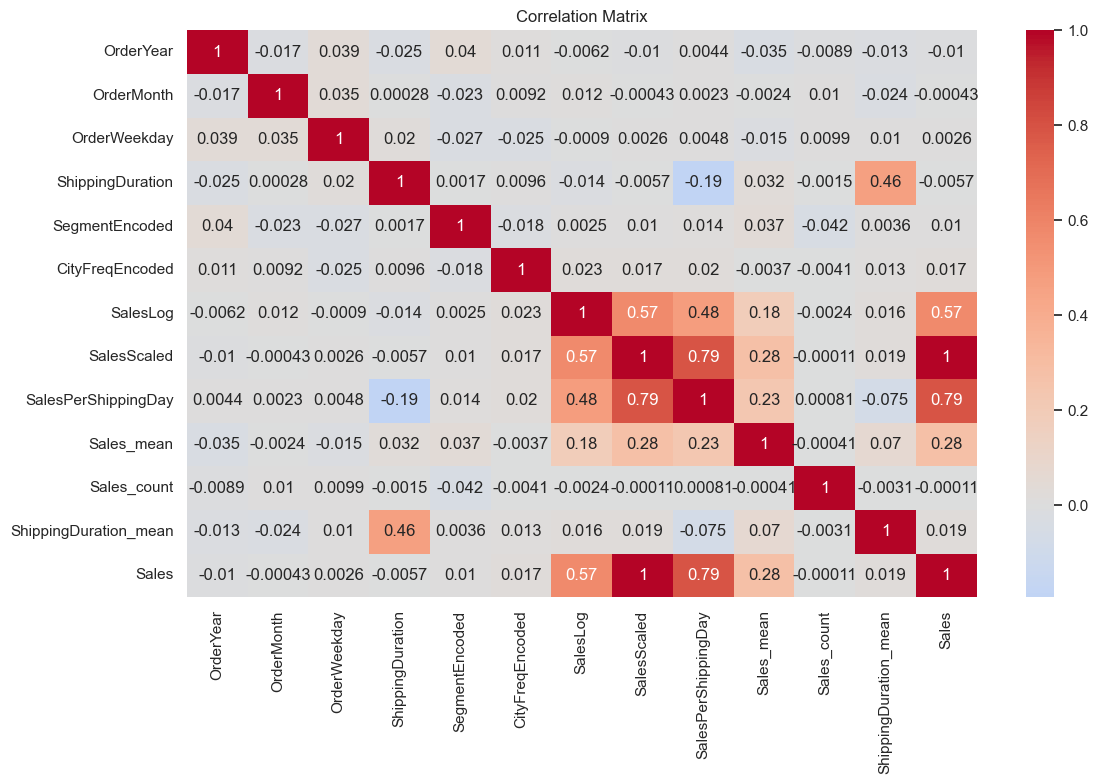

In [10]:
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png')
plt.show()

In [11]:
print("\n🔝 Top Correlations with Sales:")
sales_corr = corr_matrix['Sales'].sort_values(ascending=False)
display(pd.DataFrame(sales_corr).head(10))


🔝 Top Correlations with Sales:


,Sales
SalesScaled,1.000000
Sales,1.000000
SalesPerShippingDay,0.790975
SalesLog,0.574299
Sales_mean,0.277174
ShippingDuration_mean,0.019268
CityFreqEncoded,0.016920
SegmentEncoded,0.010304
OrderWeekday,0.002552
Sales_count,-0.000113


## 5. Temporal Analysis

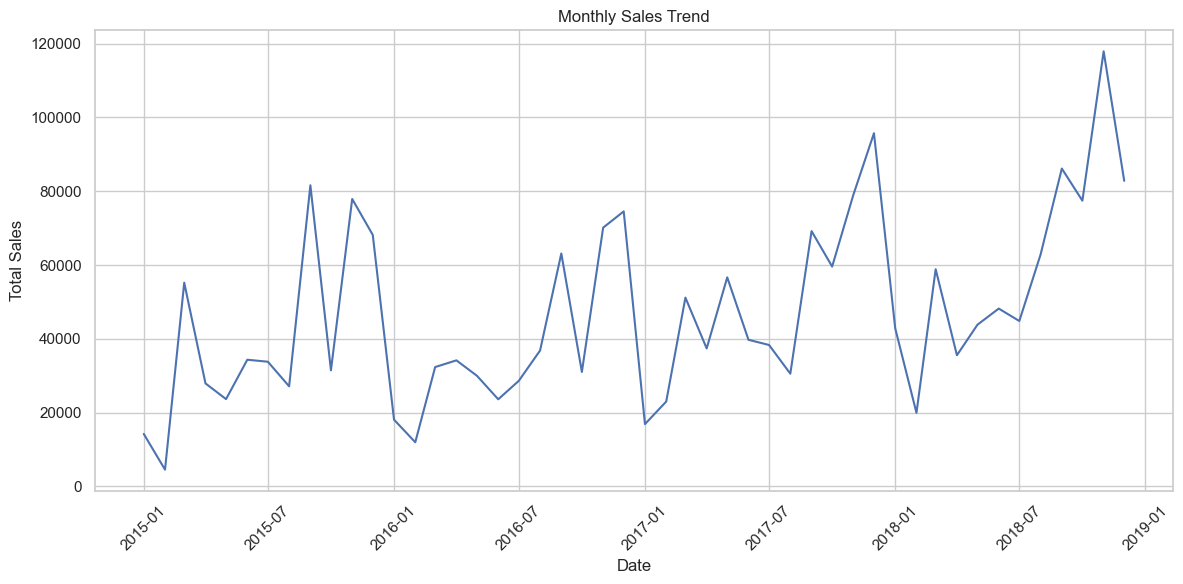

In [12]:
monthly_sales = data.groupby(['OrderYear', 'OrderMonth'])['Sales'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales['OrderYear'].astype(str) + '-' + 
                                      monthly_sales['OrderMonth'].astype(str))

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Sales', data=monthly_sales)
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/monthly_sales_trend.png')
plt.show()

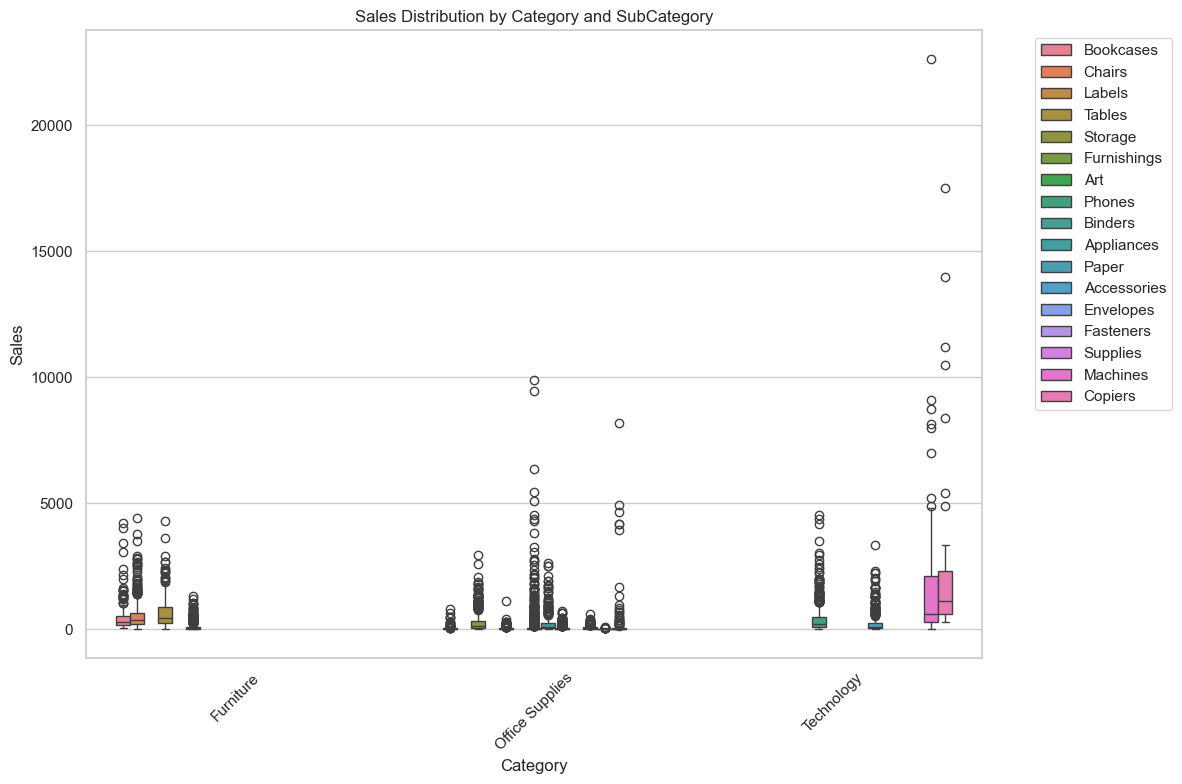

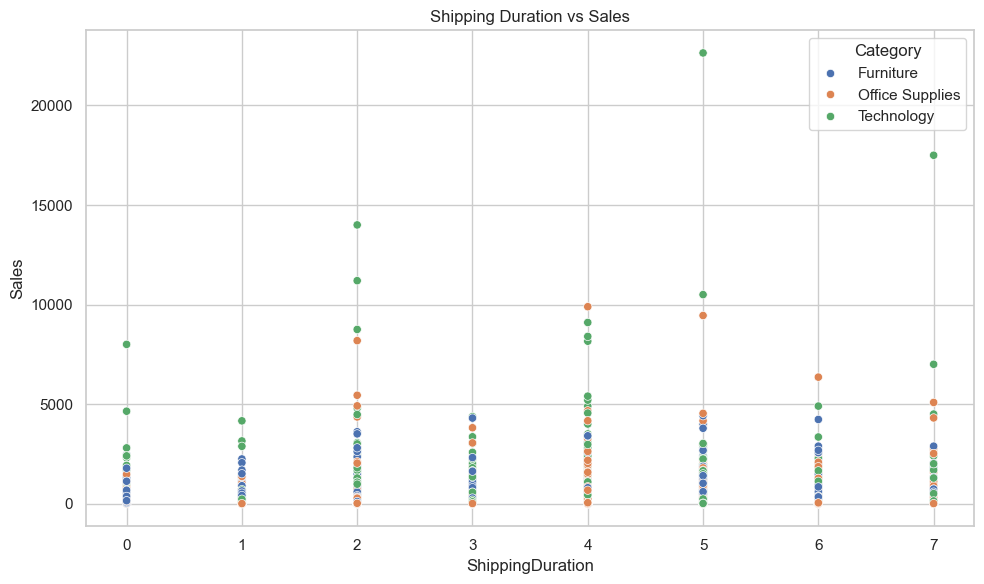

In [13]:
# Sales by Category and SubCategory
plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Sales', hue='SubCategory', data=data)
plt.title('Sales Distribution by Category and SubCategory')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('outputs/sales_by_category_subcategory.png')
plt.show()

# Shipping Duration vs Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ShippingDuration', y='Sales', hue='Category', data=data)
plt.title('Shipping Duration vs Sales')
plt.tight_layout()
plt.savefig('outputs/shipping_vs_sales.png')
plt.show()

## 6. Outlier Analysis

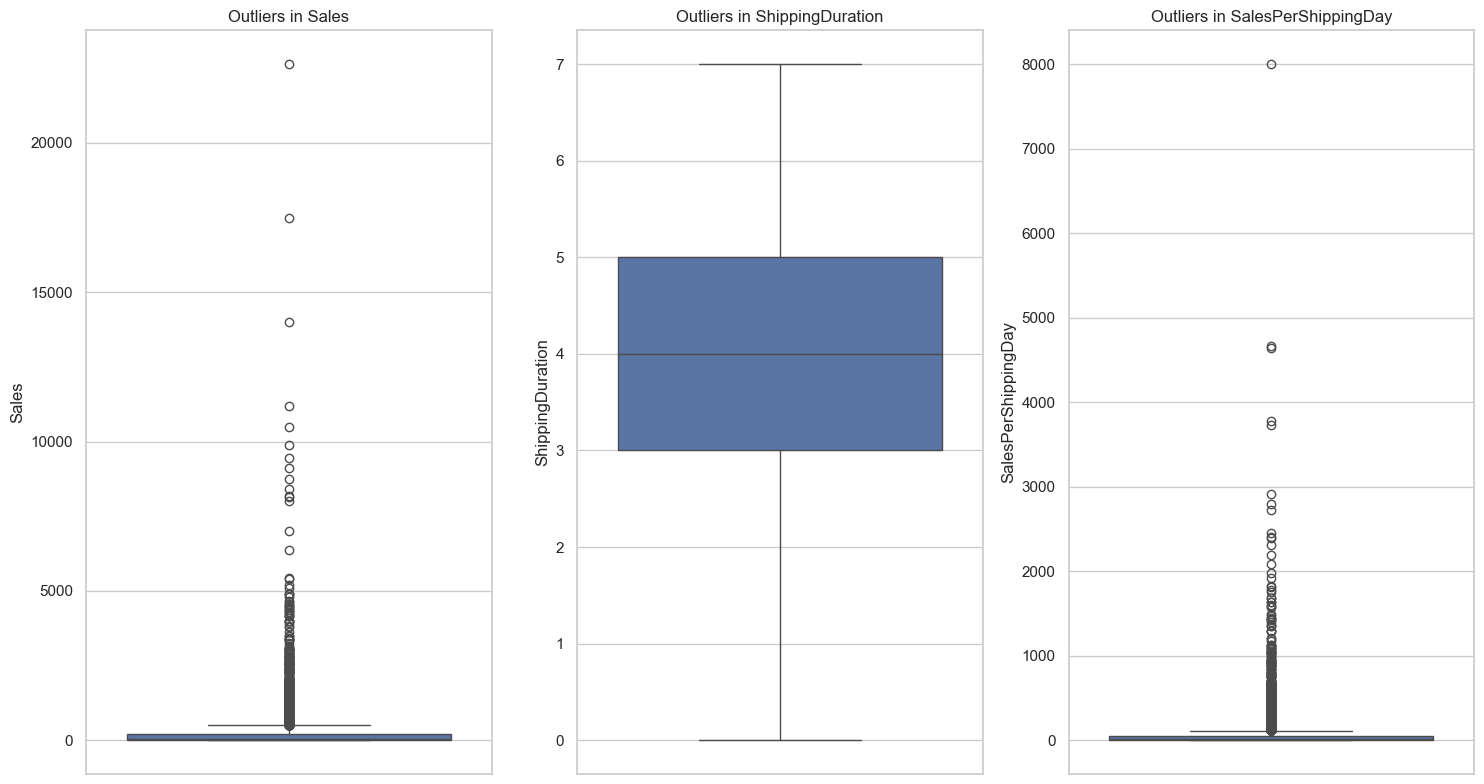

In [14]:
# Boxplot for numerical features to identify outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(['Sales', 'ShippingDuration', 'SalesPerShippingDay'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.savefig('outputs/outliers_boxplot.png')
plt.show()

In [15]:
# Z-score analysis for outliers
print("\n🔍 Extreme Outliers (Z-score > 3):")
numeric_for_outliers = data[['Sales', 'ShippingDuration', 'SalesPerShippingDay']]
z_scores = scipy.stats.zscore(numeric_for_outliers)
outliers = (abs(z_scores) > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")
display(data[outliers].sample(5, random_state=42))


🔍 Extreme Outliers (Z-score > 3):
Number of outliers detected: 175


,CustomerID,Category,SubCategory,OrderYear,OrderMonth,OrderWeekday,ShippingDuration,ShipModeFirstClass,ShipModeSecondClass,ShipModeStandardClass,SegmentEncoded,CityFreqEncoded,SalesLog,SalesScaled,SalesBinned,SalesPerShippingDay,Sales_mean,Sales_count,ShippingDuration_mean,Sales
8855,JW-15220,Office Supplies,Binders,2018,10,5,7,False,False,True,1,0.001328,8.534042,7.762795,Very High,635.495,551.551000,14,4.714286,5083.960
8234,CJ-12010,Furniture,Chairs,2018,5,1,5,False,False,True,0,0.012769,7.939130,4.116307,Very High,467.320,558.248700,20,4.650000,2803.920
6012,KF-16285,Technology,Phones,2017,3,4,1,True,False,False,2,0.074369,8.333249,6.283357,Very High,2079.456,589.125889,18,3.666667,4158.912
7485,PM-19135,Technology,Accessories,2016,12,0,5,False,True,False,2,0.001941,7.719090,3.230274,Very High,374.985,587.951714,7,4.571429,2249.910
8098,RH-19510,Technology,Machines,2017,3,4,3,True,False,False,2,0.074369,8.119279,5.001812,Very High,839.400,581.598333,12,2.833333,3357.600


## 7. Customer & RFM Analysis

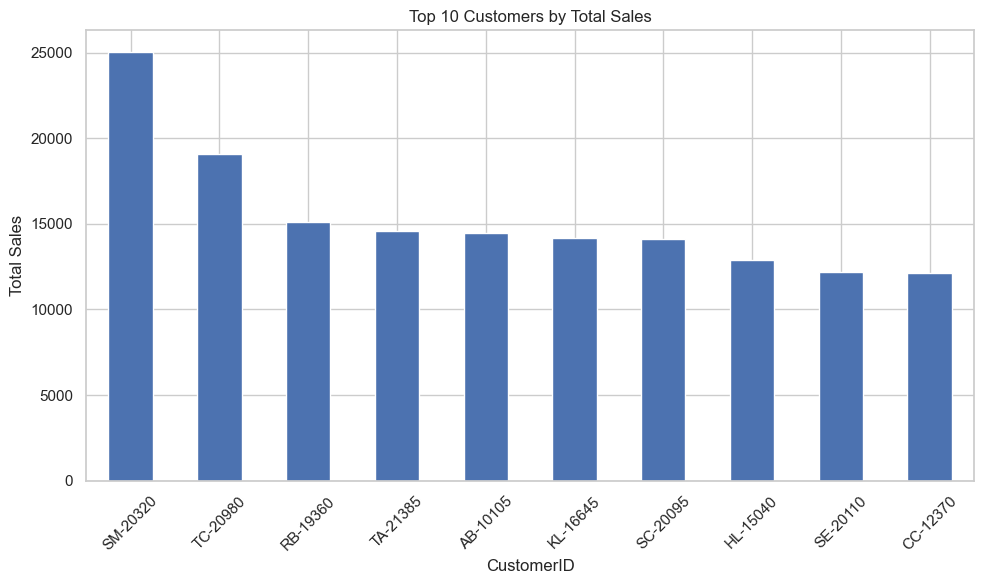

In [16]:
# Top customers by sales
top_customers = data.groupby('CustomerID')['Sales'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar')
plt.title('Top 10 Customers by Total Sales')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/top_customers.png')
plt.show()



📊 RFM Analysis:


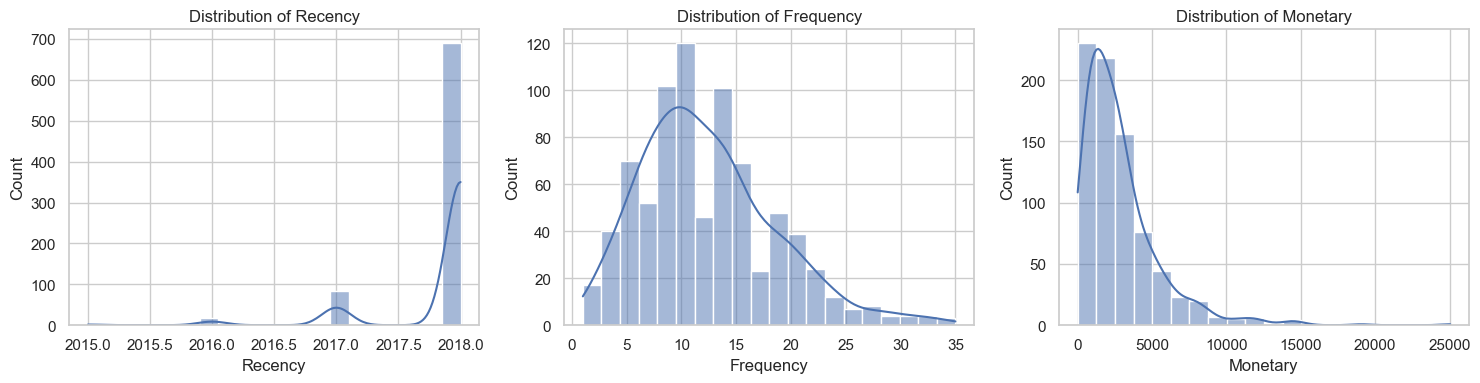

In [17]:
print("\n📊 RFM Analysis:")
rfm = data.groupby('CustomerID').agg({
    # Recency (simplified)
    'OrderYear': 'max',  
    # Frequency
    'CustomerID': 'count',  
    # Monetary
    'Sales': 'sum'  
}).rename(columns={
    'OrderYear': 'Recency',
    'CustomerID': 'Frequency',
    'Sales': 'Monetary'
})

# Plot RFM distributions
plt.figure(figsize=(15, 4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('outputs/rfm_distributions.png')
plt.show()

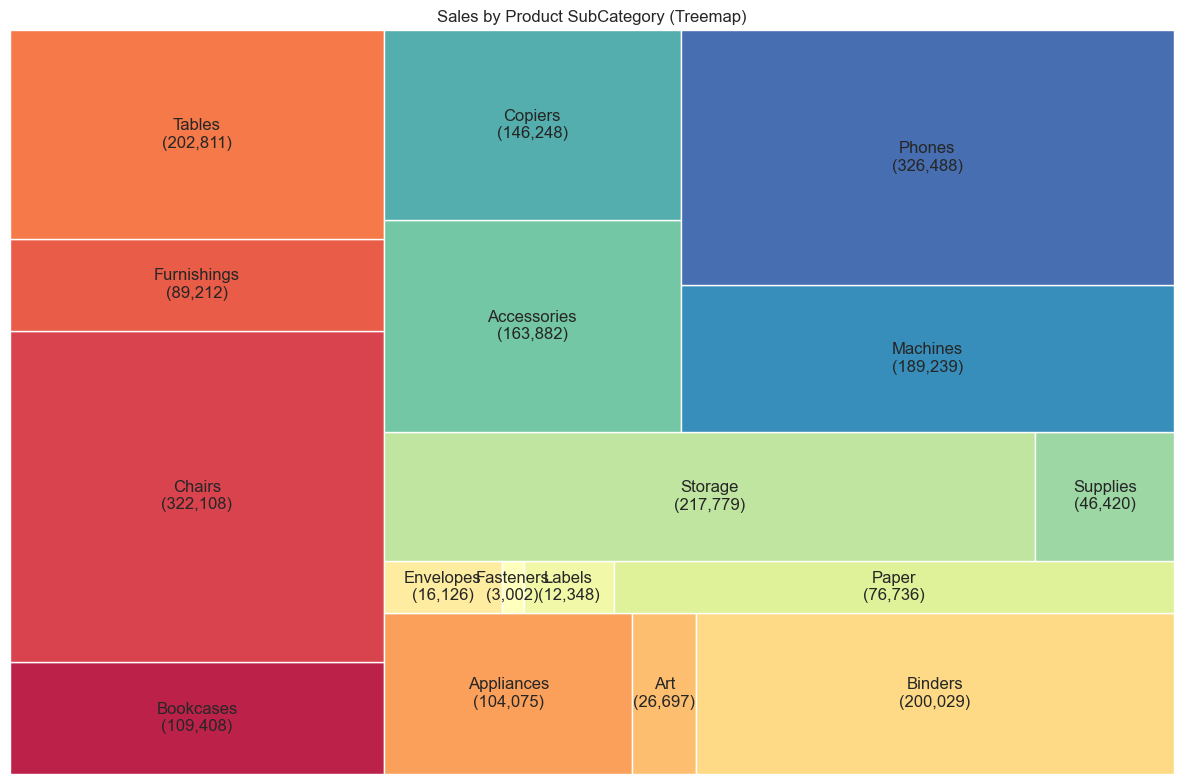

In [18]:
plt.figure(figsize=(12, 8))
category_sales = data.groupby(['Category', 'SubCategory'])['Sales'].sum().reset_index()
squarify.plot(
    sizes=category_sales['Sales'],
    label=category_sales.apply(lambda x: f"{x['SubCategory']}\n({x['Sales']:,.0f})", axis=1),
    color=sns.color_palette("Spectral", len(category_sales))
)
plt.title('Sales by Product SubCategory (Treemap)')
plt.axis('off')
plt.tight_layout()
plt.savefig('outputs/product_treemap.png')
plt.show()


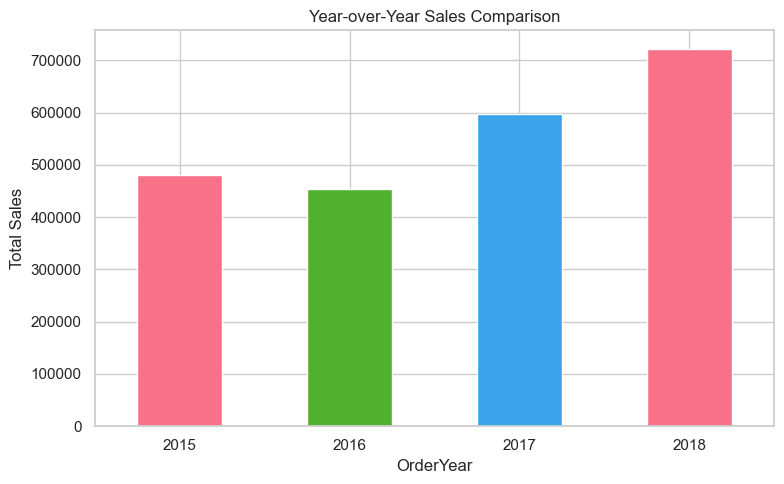

In [19]:
# Year-over-Year comparison
yearly_sales = data.groupby('OrderYear')['Sales'].sum()
plt.figure(figsize=(8, 5))
yearly_sales.plot(kind='bar', color=sns.color_palette("husl", 3))
plt.title('Year-over-Year Sales Comparison')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/yearly_comparison.png')
plt.show()

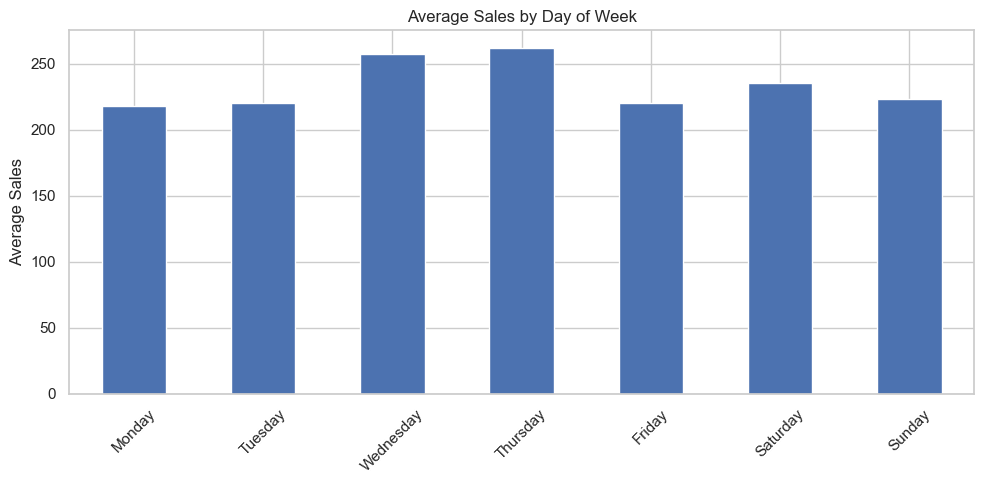

In [20]:
# Weekday analysis
weekday_sales = data.groupby('OrderWeekday')['Sales'].mean()
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 5))
weekday_sales.index = weekday_names
weekday_sales.plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/weekday_analysis.png')
plt.show()

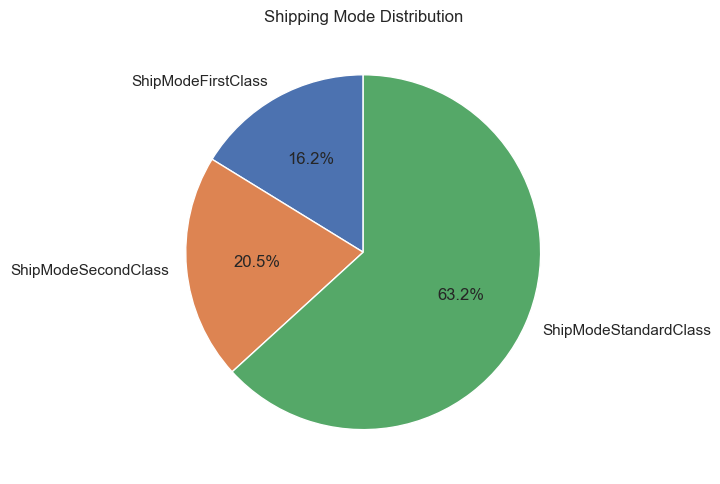

In [21]:
# Shipping mode preference
shipping_modes = data[['ShipModeFirstClass', 'ShipModeSecondClass', 'ShipModeStandardClass']].sum()
plt.figure(figsize=(8, 5))
shipping_modes.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Shipping Mode Distribution')
plt.ylabel('')
plt.tight_layout()
plt.savefig('outputs/shipping_mode_distribution.png')
plt.show()

## 8. Insights

In [22]:
insights = {
    "Top Selling Category": data.groupby('Category')['Sales'].sum().idxmax(),
    "Most Frequent Shipping Mode": shipping_modes.idxmax(),
    "Year with Highest Sales": yearly_sales.idxmax(),
    "Day with Highest Average Sales": weekday_sales.idxmax(),
    "Correlation Shipping-Sales": corr_matrix.loc['ShippingDuration', 'Sales'].round(3),
    "Average Shipping Duration": data['ShippingDuration'].mean().round(2),
    "Total Customers": data['CustomerID'].nunique(),
    "Total Sales": f"${data['Sales'].sum():,.2f}"
}

print("\n🔎 Main Findings:")
for k, v in insights.items():
    print(f"- {k}: {v}")


🔎 Main Findings:
- Top Selling Category: Technology
- Most Frequent Shipping Mode: ShipModeStandardClass
- Year with Highest Sales: 2018
- Day with Highest Average Sales: Thursday
- Correlation Shipping-Sales: -0.006
- Average Shipping Duration: 3.96
- Total Customers: 793
- Total Sales: $2,252,607.41


---
# Testing EDA_utils.py
---

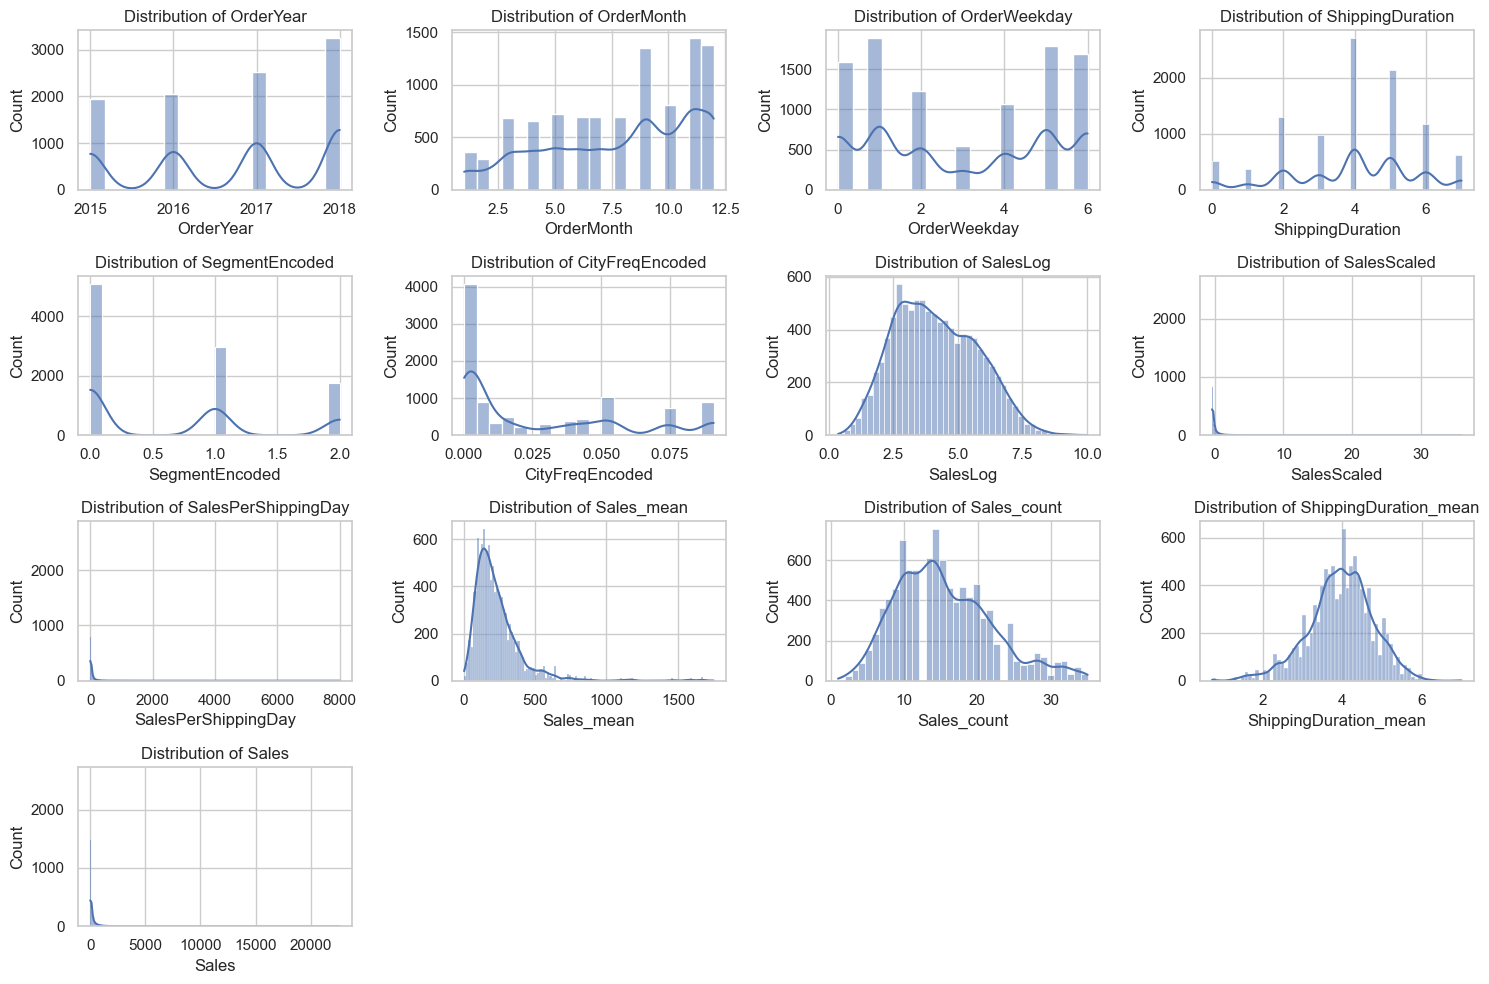

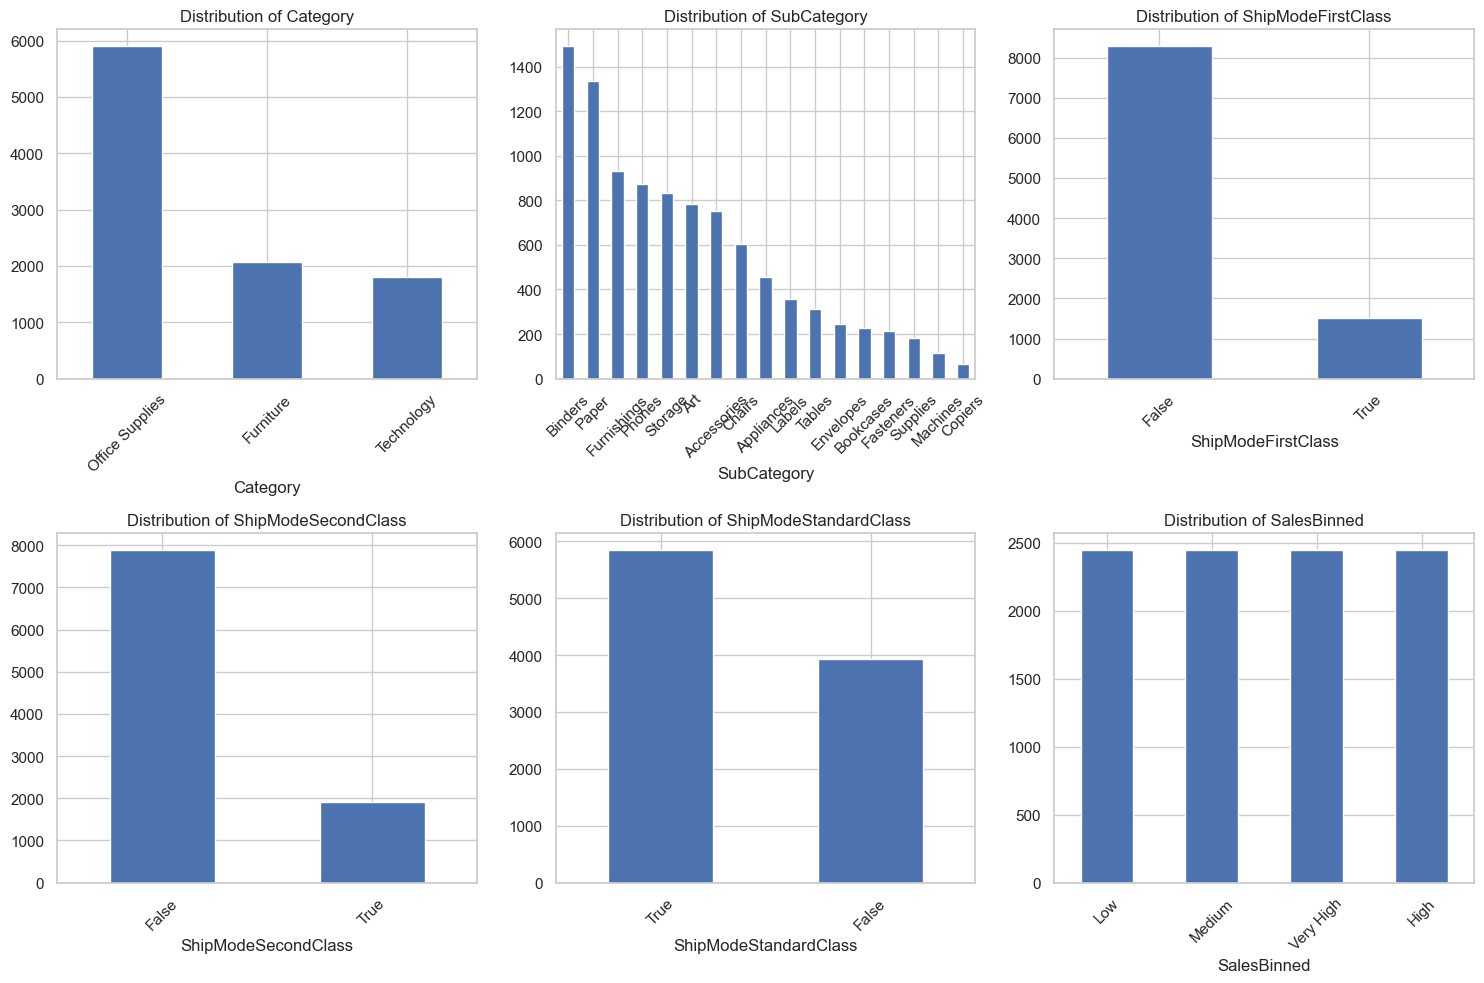

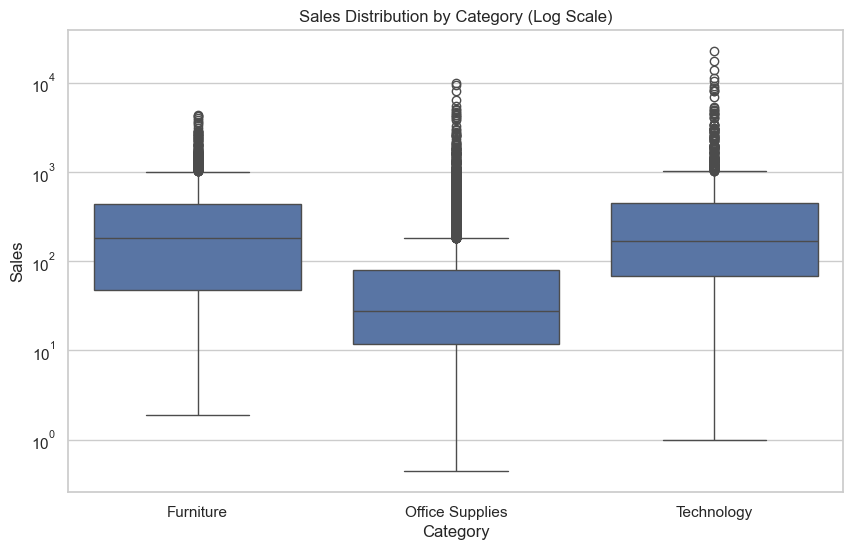

In [23]:
from EDA_utils import *

setup_environment()
data = pd.read_csv("data/processed_sales_data.csv")

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()

plot_numeric_distributions(data, numeric_cols)
plot_categorical_distributions(data, categorical_cols)
plot_sales_logscale(data)